In [1]:
#imports

from gentropy.common.session import Session
from gentropy.dataset.summary_statistics import SummaryStatistics
from pyspark.sql.functions import col
from gentropy.dataset.study_locus import StudyLocus
from gentropy.dataset.study_index import StudyIndex
import hail as hl
import os

Loading BokehJS ...

### Set up session and import data, glimpse data

In [3]:

#create session
#increase ram
# session.spark.conf.set("spark.executor.memory", "6g")
session = Session(extended_spark_conf={"spark.driver.memory": "4g"})

#path_cred_sets="gs://genetics_etl_python_playground/releases/24.03/credible_set/finngen_susie"
#local path
path_cred_sets="data/"
sl=StudyLocus.from_parquet(session=session,path=path_cred_sets)

df=sl.df
df.show()

df.printSchema()
df.groupBy('chromosome').count().show()

# Chromosome to analyze
chromosome = 1


24/06/19 13:01:46 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


ValueError: Parquet file is empty: data/

#### Count rows of data for FINNGEN

In [76]:
sl.df=df

df.show()
#total rows
df.count()
# 13966

+--------------------+----------------+----------+---------+--------------------+--------------------+----------+------+--------------+--------------+-------------------------------+-------------+-------------------+---------------+-----------------+----------------+------------------+------------+-----------+----------+-----+--------------------+
|        studyLocusId|       variantId|chromosome| position|              region|             studyId|      beta|zScore|pValueMantissa|pValueExponent|effectAlleleFrequencyFromSource|standardError|subStudyDescription|qualityControls|finemappingMethod|credibleSetIndex|credibleSetlog10BF|purityMeanR2|purityMinR2|sampleSize|ldSet|               locus|
+--------------------+----------------+----------+---------+--------------------+--------------------+----------+------+--------------+--------------+-------------------------------+-------------+-------------------+---------------+-----------------+----------------+------------------+------------+-

13966

#### Number of distinct studies

1194 studies in total

In [75]:
#number of unique study ids
df.select('studyId').distinct().count() # number of unique study ids/traits
# 1194

1194

#### Load study index

##### Number of distinct studies in index

2408

In [78]:
study_index_df=study_index.df
#number of unique study ids
print(study_index_df.select('studyId').distinct().count()) # number of unique study ids/traits
#number of rows
print(study_index_df.count())
# Both 2408 so rows = unique study ids

2408
2408


##### Join the study locus table and study index to find overlap

In [79]:
joined_df = df.join(study_index_df, on='studyId', how='inner')
joined_df.show(5)
print(joined_df.count())
# 13966 # No data loss in join

left_joined_df = df.join(study_index_df, on='studyId', how='left')
left_joined_df.show(5)
print(left_joined_df.count())
# 13966 # No data loss in left join

+--------------------+--------------------+---------------+----------+---------+--------------------+----------+------+--------------+--------------+-------------------------------+-------------+-------------------+---------------+-----------------+----------------+------------------+------------+-----------+----------+-----+--------------------+-----------+---------+--------------------+------------------------+------+------------------+--------+----------------+----------------------+---------------+------------------+----------------------------------+--------------------+------+---------+--------+---------+---------------------+-------------------+------------------+---------------+-------------+--------------------+-----------+
|             studyId|        studyLocusId|      variantId|chromosome| position|              region|      beta|zScore|pValueMantissa|pValueExponent|effectAlleleFrequencyFromSource|standardError|subStudyDescription|qualityControls|finemappingMethod|credible

In [80]:
# filter out rows where studyId is null - no entries present
#df.filter(col("studyId").isNull()).show()

#unique trait id arrays
study_index_df.select('traitFromSourceMappedIds').distinct().count()


1214

#### Filter left-joined df

Remove all rows with no EFO entries in column "traitFromSourceMappedIds"

In [ ]:
from pyspark.sql.functions import col, size

# Filter to keep rows with non-empty traitFromSourceMappedIds
filtered_df = left_joined_df.filter((col("traitFromSourceMappedIds").isNotNull()) & (size(col("traitFromSourceMappedIds")) > 0))

# Show the first 30 rows of the filtered DataFrame
filtered_df.show(30)

filtered_df.select('traitFromSourceMappedIds').distinct().show(30)
filtered_df.select('traitFromSourceMappedIds').distinct().count()



+--------------------+--------------------+--------------------+----------+---------+--------------------+----------+------+--------------+--------------+-------------------------------+-------------+-------------------+---------------+-----------------+----------------+------------------+------------+-----------+----------+-----+--------------------+-----------+---------+--------------------+------------------------+------+------------------+--------+----------------+----------------------+---------------+------------------+----------------------------------+--------------------+------+---------+--------+---------+---------------------+-------------------+------------------+---------------+-------------+--------------------+-----------+
|             studyId|        studyLocusId|           variantId|chromosome| position|              region|      beta|zScore|pValueMantissa|pValueExponent|effectAlleleFrequencyFromSource|standardError|subStudyDescription|qualityControls|finemappingMetho

729

##### Check anit-filter for rows removed

In [82]:
# show data that has empty traitFromSourceMappedIds
empty_trait_df = left_joined_df.filter((col("traitFromSourceMappedIds").isNull()) | (size(col("traitFromSourceMappedIds")) == 0))
empty_trait_df.show(5)

+--------------------+--------------------+------------------+----------+---------+--------------------+----------+------+--------------+--------------+-------------------------------+-------------+-------------------+---------------+-----------------+----------------+------------------+------------+-----------+----------+-----+--------------------+-----------+---------+--------------------+------------------------+------+------------------+--------+----------------+----------------------+---------------+------------------+----------------------------------+--------------------+------+---------+--------+---------+---------------------+-------------------+------------------+---------------+-------------+--------------------+-----------+
|             studyId|        studyLocusId|         variantId|chromosome| position|              region|      beta|zScore|pValueMantissa|pValueExponent|effectAlleleFrequencyFromSource|standardError|subStudyDescription|qualityControls|finemappingMethod|cr

##### Counts for df sizes

Study Locus df = 13966

Joined SL and SI df = 13966

Filtered left-joined DF = 8418

In [83]:
print(df.count())
print(joined_df.count())
print(filtered_df.count())


13966
13966
8418


# Run from here

In [29]:
#imports

from gentropy.common.session import Session
from gentropy.dataset.summary_statistics import SummaryStatistics
from pyspark.sql.functions import col
from gentropy.dataset.study_locus import StudyLocus
from gentropy.dataset.study_index import StudyIndex
import hail as hl
import os

# Chromosome to analyze
chromosome = 1

### Load study Index

In [12]:
# load study index
path_si="data/index/"
study_index=StudyIndex.from_parquet(session=session, path=path_si)

#### Use Gentropy SL overlap function to find overlap between CSs for using COLOC

In [3]:
from gentropy.dataset.study_locus import StudyLocus, StudyLocusOverlap
from datetime import datetime
#create session
session = Session(extended_spark_conf={"spark.driver.memory": "6g"})

#path_cred_sets="gs://genetics_etl_python_playground/releases/24.03/credible_set/finngen_susie"
#local path
path_cred_sets="data/study_locus/"
sl=StudyLocus.from_parquet(session=session,path=path_cred_sets)
study_index=StudyIndex.from_parquet(session=session, path="data/index/")
# Find Overlaps
study_locus_overlap_intra = sl.find_overlaps(study_index, intra_study_overlap=True)
study_locus_overlap_inter = sl.find_overlaps(study_index, intra_study_overlap=False)
study_locus_combined = study_locus_overlap_intra.df.unionByName(study_locus_overlap_inter.df)
print(study_locus_combined)
print(type(study_locus_combined))
date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
study_locus_combined.write.parquet(f"data/overlaps_{date}/")



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/06/19 13:06:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


24/06/19 13:06:29 WARN CacheManager: Asked to cache already cached data.
DataFrame[leftStudyLocusId: bigint, rightStudyLocusId: bigint, chromosome: string, tagVariantId: string, statistics: struct<left_logBF:double,left_posteriorProbability:double,left_beta:double,left_pValueMantissa:float,left_pValueExponent:int,right_logBF:double,right_posteriorProbability:double,right_beta:double,right_pValueMantissa:float,right_pValueExponent:int>]
<class 'pyspark.sql.dataframe.DataFrame'>


In [8]:
# Count the number of rows in the overlap DataFrame
print(study_locus_overlap_intra.df.show())
print(study_locus_overlap_intra.df.count())
print(study_locus_overlap_inter.df.show())
print(study_locus_overlap_inter.df.count())

+----------------+-----------------+----------+------------+----------+
|leftStudyLocusId|rightStudyLocusId|chromosome|tagVariantId|statistics|
+----------------+-----------------+----------+------------+----------+
+----------------+-----------------+----------+------------+----------+

None
0


+--------------------+--------------------+----------+----------------+--------------------+
|    leftStudyLocusId|   rightStudyLocusId|chromosome|    tagVariantId|          statistics|
+--------------------+--------------------+----------+----------------+--------------------+
|-3544786763432086627|-9215091430977920480|         1| 1_26607100_AC_A|{11.005551205553,...|
|-3544786763432086627|-9215091430977920480|         1|  1_26675220_A_G|{11.8288220892832...|
|-3544786763432086627|-9215091430977920480|         1|  1_26675402_G_A|{11.5844899925472...|
|-3544786763432086627|-9215091430977920480|         1|  1_26676156_T_C|{11.820897830622,...|
|-3544786763432086627|-9215091430977920480|         1|  1_26688257_C_G|{11.6264599364101...|
|-3544786763432086627|-9215091430977920480|         1|  1_26710663_T_G|{11.1957213194904...|
|-3544786763432086627|-9215091430977920480|         1|  1_26724732_A_G|{11.1957213194904...|
|-3544786763432086627|-9215091430977920480|         1|  1_26727525_A_G

4537734


#### Import StudyLocus Overlaps INTER AND INTRA for coloc

In [9]:
study_locus_overlaps = StudyLocusOverlap.from_parquet(session=session, path="data/overlaps_2024-06-19_13-06-30/")
# count the number of rows in the overlap DataFrame
print(study_locus_overlaps.df.count())

4537734


##### Example of output

In [132]:
print(study_locus_overlaps.df.show(50))
df = study_locus_overlaps.df
filtered_row = df.filter((df.leftStudyLocusId == -3544786763432086627) & (df.rightStudyLocusId == -3544786763432086627))
print(filtered_row.show())
# no overlaps for a single locus therefore no colocalisation found.

+--------------------+--------------------+----------+------------------+--------------------+
|    leftStudyLocusId|   rightStudyLocusId|chromosome|      tagVariantId|          statistics|
+--------------------+--------------------+----------+------------------+--------------------+
|-3544786763432086627|-9215091430977920480|         1|   1_26607100_AC_A|{11.005551205553,...|
|-3544786763432086627|-9215091430977920480|         1|    1_26675220_A_G|{11.8288220892832...|
|-3544786763432086627|-9215091430977920480|         1|    1_26675402_G_A|{11.5844899925472...|
|-3544786763432086627|-9215091430977920480|         1|    1_26676156_T_C|{11.820897830622,...|
|-3544786763432086627|-9215091430977920480|         1|    1_26688257_C_G|{11.6264599364101...|
|-3544786763432086627|-9215091430977920480|         1|    1_26710663_T_G|{11.1957213194904...|
|-3544786763432086627|-9215091430977920480|         1|    1_26724732_A_G|{11.1957213194904...|
|-3544786763432086627|-9215091430977920480|       

+----------------+-----------------+----------+------------+----------+
|leftStudyLocusId|rightStudyLocusId|chromosome|tagVariantId|statistics|
+----------------+-----------------+----------+------------+----------+
+----------------+-----------------+----------+------------+----------+

None


#### Colocalisation for SL overlap

In [10]:
from gentropy.method.colocalisation import Coloc
from gentropy.dataset.colocalisation import Colocalisation
import pyspark.sql.functions as F

# 1. Perform Colocalization
coloc_results = Coloc.colocalise(study_locus_overlaps)

print(coloc_results.df.show())

# 2. Analyze Colocalization Results
# Filter for significant colocalization (e.g., using a threshold for PP.H4)
significant_coloc = coloc_results.filter(F.col("h4") > 0.8)

# Print the results
print(significant_coloc.df.show())

# Print subset 7739811754326032609
filtered_row = coloc_results.df.filter((coloc_results.df.leftStudyLocusId == -7739811754326032609) | (coloc_results.df.rightStudyLocusId == -7739811754326032609))
print(filtered_row.show())


+----------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|chromosome|    leftStudyLocusId|   rightStudyLocusId|numberColocalisingVariants|                  h0|                  h1|                  h2|                  h3|                  h4|          log2h4h3|colocalisationMethod|
+----------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|         1|-7739811754326032609|-8580726767903703361|                         9|1.982276920469156...|1.341592281969666...|3.353873509699807...|  0.0217208566430716|  0.9779437558698183|5.4925985869166185|               COLOC|
|         1|-7180920194711895424|-8803538001521518159|                         2|1.445687016

+----------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+
|chromosome|    leftStudyLocusId|   rightStudyLocusId|numberColocalisingVariants|                  h0|                  h1|                  h2|                  h3|                h4|          log2h4h3|colocalisationMethod|
+----------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+
|         1|-7739811754326032609|-8580726767903703361|                         9|1.982276920469156...|1.341592281969666...|3.353873509699807...|  0.0217208566430716|0.9779437558698183|5.4925985869166185|               COLOC|
|         1|-7180920194711895424|-8803538001521518159|                         2|1.445687016280731..

+----------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+
|chromosome|    leftStudyLocusId|   rightStudyLocusId|numberColocalisingVariants|                  h0|                  h1|                  h2|                  h3|                h4|          log2h4h3|colocalisationMethod|
+----------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+
|         1|-6077882869059078660|-7739811754326032609|                         9|5.51113453516146E-11|2.079928035621036...|3.729900439702032E-9|0.013090117406130183|0.9867018860052956| 6.236064324417278|               COLOC|
|         1|-7739811754326032609|-8580726767903703361|                         9|1.982276920469156..

In [14]:
# Running coloc step function for debugging
from gentropy.colocalisation import ColocalisationStep
coloc = ColocalisationStep(session=session, credible_set_path=path_cred_sets, study_index_path=path_si, coloc_path = "output", colocalisation_method="Coloc")


24/06/19 13:20:43 WARN CacheManager: Asked to cache already cached data.
24/06/19 13:20:43 WARN CacheManager: Asked to cache already cached data.


In [15]:
print(coloc)
from gentropy.dataset.colocalisation import Colocalisation
output_path = "output/coloc/"
coloc_step_results = Colocalisation.from_parquet(session=session,path=output_path)
print(coloc_step_results.df.show())

# Print subset -7739811754326032609
filtered_row = coloc_step_results.df.filter((coloc_step_results.df.leftStudyLocusId == -7739811754326032609) | (coloc_step_results.df.rightStudyLocusId == -7739811754326032609))
print(filtered_row.show())
# Find any matching rows
for row in coloc_step_results.df.collect():
    if row.leftStudyLocusId == row.rightStudyLocusId:
        print(row)

+--------------------+--------------------+----------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+----+
|    leftStudyLocusId|   rightStudyLocusId|chromosome|colocalisationMethod|numberColocalisingVariants|                  h0|                  h1|                  h2|                  h3|                  h4|          log2h4h3|clpp|
+--------------------+--------------------+----------+--------------------+--------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+----+
|-7739811754326032609|-8580726767903703361|         1|               COLOC|                         9|1.982276920469156...|1.341592281969666...|3.353873509699807...|  0.0217208566430716|  0.9779437558698183|5.4925985869166185|null|
|-7180920194711895424|-8803538001521518159|         1|               COL

In [16]:
print(significant_coloc.df.count())

32429


In [53]:
# Show the schema of the colocalization results
schema = Colocalisation.get_schema()
#print(schema)
print(type(significant_coloc))
print(type(significant_coloc.df))


<class 'gentropy.dataset.colocalisation.Colocalisation'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [17]:
# Convert pyspark dataframe to pandas dataframe

coloc_pd_df = significant_coloc.df.toPandas()


In [18]:
# Show the first 5 rows of the pandas dataframe
coloc_pd_df.head(5)

# Summary of df
#coloc_pd_df.describe()

,chromosome,leftStudyLocusId,rightStudyLocusId,numberColocalisingVariants,h0,h1,h2,h3,h4,log2h4h3,colocalisationMethod
0,1,-7739811754326032609,-8580726767903703361,9,1.982277e-12,1.341592e-10,3.353874e-04,0.021721,0.977944,5.492599,COLOC
1,1,-7180920194711895424,-8803538001521518159,2,1.445687e-14,9.711416e-10,2.300574e-08,0.000546,0.999454,10.838132,COLOC
2,1,-7145299275585606737,-8780263499383943526,9,2.214284e-13,2.477526e-10,8.790068e-06,0.008844,0.991147,6.808270,COLOC
3,1,-6982916822936356932,-8404678411441676549,3,5.869043e-15,2.295631e-06,7.678875e-12,0.002006,0.997992,8.958893,COLOC
4,1,-6976441487811867207,-9003725253470911662,5,2.482528e-42,9.714654e-35,3.752589e-11,0.000469,0.999531,11.057644,COLOC


### Convert to matrix

In [42]:
# Convert pandas dataframe to matrix
import numpy as np
from scipy.spatial.distance import pdist, squareform
print(coloc_pd_df.head())

# Create a dictionary to store matrices for each chromosome
print(chromosome)
chromosome_matrices = {}
chromosomes_to_analyse = [f'{chromosome}']
print(chromosomes_to_analyse)
# Iterate through each chromosome
for chr in chromosomes_to_analyse:
    # Filter DataFrame for the current chromosome
    coloc_pd_filtered_df = coloc_pd_df[coloc_pd_df['chromosome'] == chr]
    print(coloc_pd_filtered_df)
    # Get unique locus IDs
    unique_locus_ids = set(coloc_pd_filtered_df['leftStudyLocusId']).union(coloc_pd_filtered_df['rightStudyLocusId'])

    # Create a zero-filled matrix
    matrix = np.zeros((len(unique_locus_ids), len(unique_locus_ids)))

    # Create pairs of locus IDs
    pairs = coloc_pd_filtered_df[['leftStudyLocusId', 'rightStudyLocusId']].values
    print(pairs)
    # Iterate through pairs and update matrix
    for pair in pairs:
        row = np.where(np.array(list(unique_locus_ids)) == pair[0])[0][0]
        col = np.where(np.array(list(unique_locus_ids)) == pair[1])[0][0]
        matrix[row, col] = 1
        matrix[col, row] = 1
    for i in range(len(matrix)):
        matrix[i,i] = 1

# Store the matrix in the dictionary
chromosome_matrices[chromosome] = matrix
print(matrix)

#check total connections
total_ones = 0
# Iterate through the matrices in the dictionary
for matrix in chromosome_matrices.values():
    # Count the number of ones in the current matrix and add to the total
    total_ones += np.count_nonzero(matrix == 1)

# Print the total number of ones
print("Total number of ones in all matrices:", total_ones)
print(f"unique connections: {int(total_ones/2)}")
#check length of matrix matches unique locus ids
print(len(matrix))
print(len(unique_locus_ids))

# Assuming you have a matrix named 'matrix'
distance_matrix = matrix - 1
print(distance_matrix)

# Assuming you have a data matrix called 'data'
# Calculate the pairwise distances between the data points
distances = pdist(matrix)

# Convert the pairwise distances to a square distance matrix
distance_matrix = squareform(distances)

# Print the distance matrix
print(distance_matrix)



  chromosome     leftStudyLocusId    rightStudyLocusId  \
0          1 -7739811754326032609 -8580726767903703361   
1          1 -7180920194711895424 -8803538001521518159   
2          1 -7145299275585606737 -8780263499383943526   
3          1 -6982916822936356932 -8404678411441676549   
4          1 -6976441487811867207 -9003725253470911662   

   numberColocalisingVariants            h0            h1            h2  \
0                           9  1.982277e-12  1.341592e-10  3.353874e-04   
1                           2  1.445687e-14  9.711416e-10  2.300574e-08   
2                           9  2.214284e-13  2.477526e-10  8.790068e-06   
3                           3  5.869043e-15  2.295631e-06  7.678875e-12   
4                           5  2.482528e-42  9.714654e-35  3.752589e-11   

         h3        h4   log2h4h3 colocalisationMethod  
0  0.021721  0.977944   5.492599                COLOC  
1  0.000546  0.999454  10.838132                COLOC  
2  0.008844  0.991147   6.808270

#### Cluster the matrix

In [43]:
import numpy as np
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
#cliuster distance matrix with ward heirarchical clustering
import matplotlib.pyplot as plt

# Perform hierarchical clustering

# linkage requires a condensed distance matrix
# The `scipy.cluster.hierarchy.linkage` function expects
# a condensed distance matrix as input.
# A condensed distance matrix is a flat array
# containing the upper triangular of the distance matrix.
# It's used to save space and avoid redundancy since a distance matrix is symmetric,
# with the diagonal elements being zero (indicating that the distance of an element to itself is zero).

from scipy.spatial.distance import squareform

# Convert the full distance matrix to a condensed one
condensed_distance_matrix = squareform(distance_matrix)
print(distance_matrix.shape)

# Perform hierarchical clustering
Z = hierarchy.linkage(condensed_distance_matrix, method='average')
print(type(Z))
print(Z)
print(Z.shape)
print(Z[0])
# Plot the dendrogram
#plt.figure(figsize=(20, 10))
#dn = hierarchy.dendrogram(Z)
#plt.xlabel('Samples')
#plt.ylabel('Distance')
#plt.title('Hierarchical Clustering Dendrogram')

# Get the clusters list

# Set the threshold to determine the number of clusters
# threshold = 10
# threshold = 5
# threshold = 3 # 67 clusters
#threshold = 1 # 368 clusters
#threshold = 0.5 # 407 clusters
threshold = 0.1 # 407 clusters

# Extract the clusters
clusters = fcluster(Z, threshold, criterion='distance')
print(type(clusters))
print(clusters)
print(clusters.shape)

# get list of locus ids unique
locus_ids = list(unique_locus_ids)
print(locus_ids)
print(len(locus_ids))
clustered_locus_ids = {}
# Iterate over unique cluster labels
for label in np.unique(clusters):
    # Get the indices of locus IDs in the current cluster
    indices = np.where(clusters == label)[0]
    print(indices)
    # Get the corresponding locus IDs from locus_ids list
    clustered_locus_ids[label] = [locus_ids[i] for i in indices]

# Print the clustered locus IDs
print("Clustered Locus IDs:")
for cluster_label, ids in clustered_locus_ids.items():
    print(f"Cluster {cluster_label}: {ids}")



(1012, 1012)
<class 'numpy.ndarray'>
[[0.00000000e+00 2.16000000e+02 0.00000000e+00 2.00000000e+00]
 [1.00000000e+00 1.40000000e+01 0.00000000e+00 2.00000000e+00]
 [2.00000000e+00 1.36000000e+02 0.00000000e+00 2.00000000e+00]
 ...
 [1.71600000e+03 2.01900000e+03 4.95284021e+00 9.41000000e+02]
 [2.01000000e+03 2.02000000e+03 5.26061658e+00 9.66000000e+02]
 [1.68400000e+03 2.02100000e+03 7.22210253e+00 1.01200000e+03]]
(1011, 4)
[  0. 216.   0.   2.]
<class 'numpy.ndarray'>
[326   1  70 ...  42 222  98]
(1012,)
[-2946753760867706877, -2005905860258365438, -5361463818512240636, -1587769186011760637, -3129970084035629049, 2401858320088500226, -6792670109632946166, 622425396178407438, 3922381209484781581, 3816807747106412559, 7407661712400314382, -795787483467108333, 4048635216261998616, -699269671455746016, 1768806930387550240, 3395509044926773280, -8235189059513282523, 4175189434935320611, 902312221484398629, 3315223905179172902, 2409010969253664809, -4220883002534948811, 2870628938573400

#### Filter for all SLs without EFOs

In [46]:
from pyspark.sql.functions import col, size

# Filter to keep rows with non-empty traitFromSourceMappedIds
study_index_df = study_index.df
left_joined_df = sl.df.join(study_index_df, on='studyId', how='left')
filtered_df = left_joined_df.filter((col("traitFromSourceMappedIds").isNotNull()) & (size(col("traitFromSourceMappedIds")) > 0))


#### Collect cluster information from extracted df, create new df for each cluster with information attached.

In [47]:

import matplotlib.pyplot as plt
import pandas as pd
import pprint
import itertools

def flatten_list(nested_list):
    return list(itertools.chain(*nested_list))


# Get the locus ids for each cluster
#clustered_locus_ids = clustered_locus_ids.values()
print(filtered_df.columns)
cluster_efos = []
# Iterate over each cluster
dict = {}
for cluster_id, locus_ids in clustered_locus_ids.items():
    # Filter the study locus table for the current cluster
    extracted_df = filtered_df.filter(filtered_df['studyLocusId'].isin(locus_ids))
    #extracted_df.show(5)
    # study_index_df_filtered = filtered_df.filter(filtered_df['studyLocusId'].isin(locus_ids))
    # count number of EFOs
    unqiue_EFOs = extracted_df.select('traitFromSourceMappedIds').distinct().count()

    traits = [row['traitFromSourceMappedIds'] for row in extracted_df.select('traitFromSourceMappedIds').distinct().collect()]
    traits_unique = set(flatten_list(traits))
    betas = [row[0] for row in extracted_df.select('beta').collect()]
    avg_beta = extracted_df.select('beta').agg({'beta': 'avg'}).first()[0]
    # chr = extracted_df.select('chromosome').distinct().collect()[0][0]
    h4 = extracted_df.select('h4').collect()
    avg_h4 = extracted_df.select('h4').agg({'h4': 'avg'}).first()[0]

    dict = {
        'cluster_id': cluster_id,
        'locus_ids': locus_ids,
        'unique_efos': unqiue_EFOs,
        'all_efos': traits_unique,
        'h4': h4,
        'avg_h4': avg_h4,
        'beta': betas,
        'average_beta': avg_beta,
        'size': len(locus_ids),
        'size_efos': len(traits_unique),
    }
    cluster_efos.append(dict)

pprint.pprint(cluster_efos)

['studyId', 'studyLocusId', 'variantId', 'chromosome', 'position', 'region', 'beta', 'zScore', 'pValueMantissa', 'pValueExponent', 'effectAlleleFrequencyFromSource', 'standardError', 'subStudyDescription', 'qualityControls', 'finemappingMethod', 'credibleSetIndex', 'credibleSetlog10BF', 'purityMeanR2', 'purityMinR2', 'sampleSize', 'ldSet', 'locus', 'projectId', 'studyType', 'traitFromSource', 'traitFromSourceMappedIds', 'geneId', 'tissueFromSourceId', 'pubmedId', 'publicationTitle', 'publicationFirstAuthor', 'publicationDate', 'publicationJournal', 'backgroundTraitFromSourceMappedIds', 'initialSampleSize', 'nCases', 'nControls', 'nSamples', 'cohorts', 'ldPopulationStructure', 'discoverySamples', 'replicationSamples', 'qualityControls', 'analysisFlags', 'summarystatsLocation', 'hasSumstats']
[{'all_efos': {'EFO_0000319',
               'EFO_0000337',
               'EFO_0000398',
               'EFO_0000685',
               'EFO_0000734',
               'EFO_0002609',
               'EF

#### Plotting clusters for EFOs

In [48]:
import plotly.graph_objects as go
import plotly

# Extract cluster ids, locus_ids, and unique efos from the dictionary
cluster_ids = [x['cluster_id'] for x in cluster_efos]  # cluster_efos['cluster_id']
locus_ids = [x['locus_ids'] for x in cluster_efos]
unique_efos = [x['unique_efos'] for x in cluster_efos]

# old code to get cluster ids, locus ids and unique efos, from dict no longer present
# locus_ids = cluster_efos['locus_ids']
# unique_efos = cluster_efos['unique_efos']

# # Inspect single cluster
# cluster_id = cluster_efos[0]['cluster_id']
# locus_ids = cluster_efos[0]['locus_ids']
# unique_efos = cluster_efos[0]['unique_efos']

# Create a list of cluster labels for the x-axis
cluster_labels = [f'Cluster {i}'for i in range(1, max(cluster_ids) + 1)]

# Create a list of efos for the y-axis
efos = [unique_efos] * cluster_id
df_efos = pd.DataFrame(cluster_efos)
# Create a bar plot using Plotly
fig = go.Figure(data=[go.Bar(x=df_efos['cluster_id'], y=df_efos['unique_efos'])])
# hover text
fig.update_traces(text=df_efos['unique_efos'], textposition='outside')
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.7)
#change hover text with cluster id
fig.update_traces(hoverinfo='text')
# labels for x and y axis
fig.update_layout(title=f'EFOS for Each Cluster in Chr{chromosome}', xaxis_title='Cluster', yaxis_title='EFOS')


# Display the plot
fig.show()

# Save the plot to an HTML file
from datetime import datetime
date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
#plotly.offline.plot(fig, filename='cluster_efos.html')
plotly.offline.plot(fig, filename=f'Chr_{chr}_cluster_efos_{date}.html')

'Chr_1_cluster_efos_2024-06-19_14-00-54.html'

### Investigate cluster 1 in CHR1 with EFOs of 23.

In [52]:
cluster_efos_df = pd.DataFrame(cluster_efos)
print(cluster_efos_df.columns)
cluster_1_df = cluster_efos_df[cluster_efos_df['cluster_id'] == 1]
print(cluster_1_df)
print(list(cluster_1_df['all_efos']))

Index(['cluster_id', 'locus_ids', 'unique_efos', 'all_efos', 'beta',
       'average_beta', 'size', 'size_efos'],
      dtype='object')
   cluster_id                                          locus_ids  unique_efos  \
0           1  [-2005905860258365438, 1768806930387550240, 50...           23   

                                            all_efos  \
0  {EFO_0009605, EFO_0005755, EFO_0000319, EFO_10...   

                                                beta  average_beta  size  \
0  [-0.228059, -0.187473, -0.230541, 0.388795, -0...      -0.08431    46   

   size_efos  
0         25  
[{'EFO_0009605', 'EFO_0005755', 'EFO_0000319', 'EFO_1001986', 'EFO_0000734', 'EFO_0009460', 'EFO_1000627', 'EFO_0009406', 'Orphanet_442', 'EFO_0002609', 'GO_0042493', 'MONDO_0002280', 'EFO_0000337', 'EFO_0005140', 'EFO_0004237', 'HP_0003040', 'EFO_0006812', 'EFO_0000685', 'EFO_0009664', 'EFO_0000398', 'EFO_0004283', 'EFO_0005856', 'MONDO_0001898', 'EFO_0003839', 'EFO_0009190'}]


### Eigen Values

In [53]:
# Find the Eigen values
import numpy as np
import numpy as np
from sklearn.decomposition import PCA

print(min(np.linalg.eigvalsh(distance_matrix)))
print(max(np.linalg.eigvalsh(distance_matrix)))
print(len(np.linalg.eigvalsh(distance_matrix)))
print(sum(np.linalg.eigvalsh(distance_matrix))/len(np.linalg.eigvalsh(distance_matrix)))

negative_count = np.sum(np.linalg.eigvalsh(distance_matrix) < 0)
print(negative_count)

# Eigenvalues are a set of scalars associated with a linear system of equations.
# They represent the values by which a matrix can be scaled without changing
# the direction of its corresponding eigenvectors.
# In other words, eigenvalues determine the stretching or compression factor
# of the eigenvectors in a linear transformation.
# They are often used in various mathematical and scientific applications,
# such as solving differential equations, analyzing network structures,
# and performing dimensionality reduction techniques
# like Principal Component Analysis (PCA).


eigenvalues, eigenvectors = np.linalg.eig(distance_matrix)
print(eigenvalues)
max_eigenvalue = max(eigenvalues)
min_eigenvalue = min(eigenvalues)
print("Max Eigenvalue:", max_eigenvalue)
print("Min Eigenvalue:", min_eigenvalue)



-662.2453658562708
3956.4022188363138
1012
4.49355089808759e-15
668
[ 3.95640222e+03+0.00000000e+00j -6.62245366e+02+0.00000000e+00j
 -1.99515412e+02+0.00000000e+00j ... -4.55799823e-34+0.00000000e+00j
 -4.70875858e-18+2.37755342e-18j -4.70875858e-18-2.37755342e-18j]
Max Eigenvalue: (3956.402218836313+0j)
Min Eigenvalue: (-662.2453658562744+0j)


### PCA plot for distance matrix

Reduced Matrix:
Explained Variance Ratio:
[0.86076508 0.05905489]
Principal Components:


/home/rswilson1/anaconda3/envs/py310/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/rswilson1/anaconda3/envs/py310/lib/python3.10/site-packages/matplotlib/collections.py:197: ComplexWarning:

Casting complex values to real discards the imaginary part



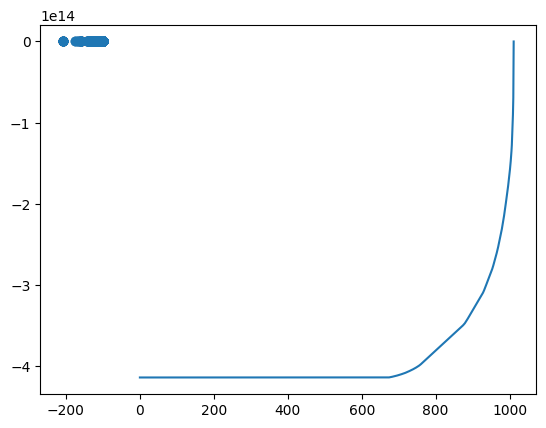

In [54]:
import plotly.express as px

# Create a PCA object
pca = PCA(n_components=2)  # Specify the number of components you want to keep

# Fit the PCA model to the matrix
pca.fit(distance_matrix)

#2D explained variance plot
components = pca.fit_transform(distance_matrix)
fig = px.scatter(components, x=0, y=1)
fig.show()
plotly.offline.plot(fig, filename=f'Chr_{chr}_PCA_{date}.html')


# Transform the matrix to the reduced dimensionality
reduced_matrix = pca.transform(distance_matrix)

# Access the explained variance ratio of each component
explained_variance_ratio = pca.explained_variance_ratio_

# Access the principal components
principal_components = pca.components_

# Print the results
print("Reduced Matrix:")
# print(reduced_matrix)
print("Explained Variance Ratio:")
print(explained_variance_ratio)
print("Principal Components:")
# print(principal_components)

order_of_importance = np.argsort(eigenvalues)[::-1]

# utilize the sort order to sort eigenvalues and eigenvectors
sorted_eigenvalues = eigenvalues[order_of_importance]
sorted_eigenvectors = eigenvectors[:,order_of_importance] # sort the columns

# explained_variance
explained_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)

k = 2 # select the number of principal components
reduced_data = np.matmul(distance_matrix, sorted_eigenvectors[:,:k]) # transform the original data

#plot scatter plot of reduced data
plt.scatter(reduced_data[:,0], reduced_data[:,1], alpha=0.3)

#plot the explained variance
import matplotlib.pyplot as plt
plt.plot(np.cumsum(explained_variance))

##### Heatmap

In [55]:
import numpy as np
import plotly.express as px

# # Create the heatmap
# sns.heatmap(distance_matrix, annot=True, cmap="YlGnBu")

# # Add labels and title (optional)
# plt.xlabel("X-axis Label")
# plt.ylabel("Y-axis Label")
# plt.title("Heatmap of Your Matrix")

# # Show the plot
# plt.show()

fig = px.imshow(distance_matrix, text_auto=True)
fig.show()
plotly.offline.plot(fig, filename=f'Chr_{chr}_heatmap_{date}.html')

'Chr_1_heatmap_2024-06-19_14-00-54.html'

### Method 2
##### Form clusters by looping over most signifcant CS by P-Value.

Method 2 loop - functional

In [68]:
# Create clusters based on p value groups.
# Imports and set variables
from pyspark.sql.functions import col

# Create a set to store collected variants for efficient lookup
collected_variants = set()  # variants already seen

# DF for p value variants in CHR

# study locus and study index combined table - RENAME at some point
left_joined_df = sl.df.join(study_index_df, on='studyId', how='left')
left_joined_df_filtered = left_joined_df.filter((col("traitFromSourceMappedIds").isNotNull()) & (size(col("traitFromSourceMappedIds")) > 0))
# Create a new column for p-value, p-value = pValueMantissa * 10^pValueExponent
left_joined_df_filtered = left_joined_df_filtered.withColumn("p_value", F.col(
    "pValueMantissa") * F.pow(10, F.col("pValueExponent")))
pvalue_ordered_sl_si_df = left_joined_df_filtered.orderBy("p_value")
print(pvalue_ordered_sl_si_df.columns)

# Filter the DataFrame for the chromosome of interest
chr_df = pvalue_ordered_sl_si_df.filter(F.col("chromosome") == chromosome)
chr_pd_df = chr_df.toPandas()  # convert to pandas dataframe
chr_pd_df.head(5)
print(f"{len(chr_pd_df)} variants in chromosome {chromosome}.")

# DF for coloc results in CHR
coloc_pd_df = significant_coloc.df.toPandas()

print(coloc_pd_df.columns)
print(coloc_pd_df.head(5))


# Loop over DF with Pvalues ordered, create clusters from coloc DF.

# Check if var is in cluster, if not create new cluster.

# Create list to store clusters
cluster_data = []
pvalue_cluster_df = pd.DataFrame()
# Loop over the DataFrame
for index, row in chr_pd_df.iterrows():
    if index < 1:
        print(row)
    # Get the variant ID
    variant_id = row["studyLocusId"]
    pvalue = row["p_value"]
    if index < 1:
        print(variant_id)
    # Check if the variant is already in a cluster
    if variant_id in collected_variants:
        continue

    # Get the coloc results for the variant
    coloc_results = coloc_pd_df[(coloc_pd_df["leftStudyLocusId"] == variant_id) | (
        coloc_pd_df["rightStudyLocusId"] == variant_id)]

    # Get list of coloc variant study locus ids
    coloc_variant_ids = set(coloc_results["leftStudyLocusId"]).union(
        set(coloc_results["rightStudyLocusId"])
        )
    print(coloc_variant_ids)
    # Filter and create new DataFrame with clusterID
    if coloc_variant_ids:
        new_df = chr_pd_df[chr_pd_df['studyLocusId'].isin(coloc_variant_ids)].copy()
        new_df['ClusterId'] = int(index + 1)
        print(index)
        print(new_df.head(5))
        pvalue_cluster_df = pd.concat([pvalue_cluster_df, new_df], axis=0, join="outer")
        # get EFO list
        # Count EFOs unique
    else:
        print("No coloc variants found.")

    # Add the variant to the collected variants set
    collected_variants.add(variant_id)
    for var_id in coloc_variant_ids:
        collected_variants.add(var_id)
    if index < 5:
        print("First variants")
        print(f"P-Value: {pvalue}")
        print(collected_variants)
        print(len(collected_variants))


pvalue_cluster_df.reset_index(drop=True, inplace=True)
print(pvalue_cluster_df.head(5))
print(len(pvalue_cluster_df))
print(pvalue_cluster_df.columns)



# TODO: Create a function to check if a variant is in a cluster
# TODO: Create a function to create a new cluster
# TODO: Create a function to remove variant from each df.
# TODO: Test loop and efficiency.

['studyId', 'studyLocusId', 'variantId', 'chromosome', 'position', 'region', 'beta', 'zScore', 'pValueMantissa', 'pValueExponent', 'effectAlleleFrequencyFromSource', 'standardError', 'subStudyDescription', 'qualityControls', 'finemappingMethod', 'credibleSetIndex', 'credibleSetlog10BF', 'purityMeanR2', 'purityMinR2', 'sampleSize', 'ldSet', 'locus', 'projectId', 'studyType', 'traitFromSource', 'traitFromSourceMappedIds', 'geneId', 'tissueFromSourceId', 'pubmedId', 'publicationTitle', 'publicationFirstAuthor', 'publicationDate', 'publicationJournal', 'backgroundTraitFromSourceMappedIds', 'initialSampleSize', 'nCases', 'nControls', 'nSamples', 'cohorts', 'ldPopulationStructure', 'discoverySamples', 'replicationSamples', 'qualityControls', 'analysisFlags', 'summarystatsLocation', 'hasSumstats', 'p_value']


837 variants in chromosome 1.


Index(['chromosome', 'leftStudyLocusId', 'rightStudyLocusId',
       'numberColocalisingVariants', 'h0', 'h1', 'h2', 'h3', 'h4', 'log2h4h3',
       'colocalisationMethod'],
      dtype='object')
  chromosome     leftStudyLocusId    rightStudyLocusId  \
0          1 -7739811754326032609 -8580726767903703361   
1          1 -7180920194711895424 -8803538001521518159   
2          1 -7145299275585606737 -8780263499383943526   
3          1 -6982916822936356932 -8404678411441676549   
4          1 -6976441487811867207 -9003725253470911662   

   numberColocalisingVariants            h0            h1            h2  \
0                           9  1.982277e-12  1.341592e-10  3.353874e-04   
1                           2  1.445687e-14  9.711416e-10  2.300574e-08   
2                           9  2.214284e-13  2.477526e-10  8.790068e-06   
3                           3  5.869043e-15  2.295631e-06  7.678875e-12   
4                           5  2.482528e-42  9.714654e-35  3.752589e-11   

     

In [79]:
### Re-write to include more ids in clusters to enlarge rather than exclude
# Create clusters based on p value groups.
# Imports and set variables
from pyspark.sql.functions import col

# Create a set to store collected variants for efficient lookup
collected_variants = set()  # variants already seen

# DF for p value variants in CHR

# study locus and study index combined table - RENAME at some point
left_joined_df = sl.df.join(study_index_df, on='studyId', how='left')
left_joined_df_filtered = left_joined_df.filter((col("traitFromSourceMappedIds").isNotNull()) & (size(col("traitFromSourceMappedIds")) > 0))
# Create a new column for p-value, p-value = pValueMantissa * 10^pValueExponent
left_joined_df_filtered = left_joined_df_filtered.withColumn("p_value", F.col(
    "pValueMantissa") * F.pow(10, F.col("pValueExponent")))
pvalue_ordered_sl_si_df = left_joined_df_filtered.orderBy("p_value")
print(pvalue_ordered_sl_si_df.columns)

# Filter the DataFrame for the chromosome of interest
chr_df = pvalue_ordered_sl_si_df.filter(F.col("chromosome") == chromosome)
chr_pd_df = chr_df.toPandas()  # convert to pandas dataframe
chr_pd_df.head(5)
print(f"{len(chr_pd_df)} variants in chromosome {chromosome}.")

# DF for coloc results in CHR
coloc_pd_df = significant_coloc.df.toPandas()

print(coloc_pd_df.columns)
print(coloc_pd_df.head(5))


# Loop over DF with Pvalues ordered, create clusters from coloc DF.

# Check if var is in cluster, if not create new cluster.

# Create list to store clusters
cluster_data = []
pvalue_cluster_df = pd.DataFrame()
singletons = pd.DataFrame()
# Loop over the DataFrame
counter = 0
for index, row in chr_pd_df.iterrows():
    if index < 1:
        print(row)
    # Get the variant ID
    variant_id = row["studyLocusId"]
    pvalue = row["p_value"]
    if index < 1:
        print(variant_id)
    # Check if the variant is already in a cluster
    if variant_id in collected_variants:
        cluster_id = pvalue_cluster_df[pvalue_cluster_df['studyLocusId'] == variant_id]['ClusterId'].values[0]
        print(f"Variant {variant_id} is already in cluster {cluster_id}.")
        # Append all coloc variants to the cluster
        coloc_results = coloc_pd_df[(coloc_pd_df["leftStudyLocusId"] == variant_id) | (
            coloc_pd_df["rightStudyLocusId"] == variant_id)]
        coloc_variant_ids = set(coloc_results["leftStudyLocusId"]).union(
            set(coloc_results["rightStudyLocusId"])
            )
        print(coloc_variant_ids)
        # Filter and create new DataFrame with clusterID
        if coloc_variant_ids:
            new_df = chr_pd_df[chr_pd_df['studyLocusId'].isin(coloc_variant_ids)].copy()
            new_df['ClusterId'] = int(cluster_id)
            print(index)
            print(new_df.head(5))
            pvalue_cluster_df = pd.concat([pvalue_cluster_df, new_df], axis=0, join="outer")
            # get EFO list
            # Count EFOs unique
        else:
            print("No coloc variants found.")
        # Append the variants to the collected variants set
        for var_id in coloc_variant_ids:
            collected_variants.add(var_id)
        continue

    # Not in collected variants to create new cluster
    # Get the coloc results for the variant
    coloc_results = coloc_pd_df[(coloc_pd_df["leftStudyLocusId"] == variant_id) | (
        coloc_pd_df["rightStudyLocusId"] == variant_id)]
    # remove all matching pairs for variant_id
    coloc_pd_df = coloc_pd_df[~((coloc_pd_df["leftStudyLocusId"] == variant_id) | (
        coloc_pd_df["rightStudyLocusId"] == variant_id))]
    # Get list of coloc variant study locus ids
    coloc_variant_ids = set(coloc_results["leftStudyLocusId"]).union(
        set(coloc_results["rightStudyLocusId"])
        )
    print(coloc_variant_ids)
    # Filter and create new DataFrame with clusterID
    if coloc_variant_ids:
        new_df = chr_pd_df[chr_pd_df['studyLocusId'].isin(coloc_variant_ids)].copy()
        counter =+ 1
        new_df['ClusterId'] = counter  # int(index + 1)
        print(index)
        print(new_df.head(5))
        pvalue_cluster_df = pd.concat([pvalue_cluster_df, new_df], axis=0, join="outer")
        # get EFO list
        # Count EFOs unique
    else:
        print("No coloc variants found.")
        single_locus = chr_pd_df[chr_pd_df['studyLocusId'] == variant_id]
        print(type(single_locus))
        singletons = pd.concat([singletons, single_locus], axis=0, join="outer")

    # Add the variant to the collected variants set
    collected_variants.add(variant_id)
    for var_id in coloc_variant_ids:
        collected_variants.add(var_id)
    if index < 5:
        print("First variants")
        print(f"P-Value: {pvalue}")
        print(collected_variants)
        print(len(collected_variants))


pvalue_cluster_df.reset_index(drop=True, inplace=True)
print(pvalue_cluster_df.head(5))
print(len(pvalue_cluster_df))
print(pvalue_cluster_df.columns)



# TODO: Create a function to check if a variant is in a cluster
# TODO: Create a function to create a new cluster
# TODO: Create a function to remove variant from each df.
# TODO: Test loop and efficiency.

['studyId', 'studyLocusId', 'variantId', 'chromosome', 'position', 'region', 'beta', 'zScore', 'pValueMantissa', 'pValueExponent', 'effectAlleleFrequencyFromSource', 'standardError', 'subStudyDescription', 'qualityControls', 'finemappingMethod', 'credibleSetIndex', 'credibleSetlog10BF', 'purityMeanR2', 'purityMinR2', 'sampleSize', 'ldSet', 'locus', 'projectId', 'studyType', 'traitFromSource', 'traitFromSourceMappedIds', 'geneId', 'tissueFromSourceId', 'pubmedId', 'publicationTitle', 'publicationFirstAuthor', 'publicationDate', 'publicationJournal', 'backgroundTraitFromSourceMappedIds', 'initialSampleSize', 'nCases', 'nControls', 'nSamples', 'cohorts', 'ldPopulationStructure', 'discoverySamples', 'replicationSamples', 'qualityControls', 'analysisFlags', 'summarystatsLocation', 'hasSumstats', 'p_value']
837 variants in chromosome 1.


In [75]:
#extract rows for cluster 1
cluster_1 = pvalue_cluster_df[pvalue_cluster_df['ClusterId'] == 1]
print(cluster_1)
# extract traitsid for cluster 1
print(cluster_1['traitFromSourceMappedIds'])
print(len(cluster_1))

                                  studyId         studyLocusId  \
0               FINNGEN_R10_D3_COAGDEFNAS -8105721228842364322   
1     FINNGEN_R10_N14_ENDOMETRIOSIS_OVARY  6829486655767890924   
2          FINNGEN_R10_D3_ANAEMIA_IRONDEF  4819455697282845550   
3                 FINNGEN_R10_I9_VEINSOTH  4715700765934321793   
4                      FINNGEN_R10_FG_CVD  9134297415547211454   
...                                   ...                  ...   
3217                   FINNGEN_R10_H7_AMD   154753042888099461   
3218                   FINNGEN_R10_H7_AMD -6227351701152294655   
3219                  FINNGEN_R10_WET_AMD  7790436515137591031   
3220                  FINNGEN_R10_DRY_AMD -8834930523111634627   
3221              FINNGEN_R10_I9_CORATHER   220576144930142365   

                        variantId chromosome   position  \
0                 1_169355555_T_C          1  169355555   
1                 1_169549811_C_T          1  169549811   
2                 1_169549811_

In [76]:
### Get unique EFOs for each cluster

import pandas as pd
import seaborn as sns
import plotly.express as px
from datetime import datetime
# Drop one of the duplicate 'qualityControls' columns
pvalue_cluster_df = pvalue_cluster_df.loc[:, ~pvalue_cluster_df.columns.duplicated()]

# Function to extract unique EFO IDs from lists
def extract_unique_efos(efo_list):
    if isinstance(efo_list, list):  # Ensure it's a list
        return set(efo for efo in efo_list if isinstance(efo, str))  # Handle potential non-string elements
    else:
        return set()  # Return an empty set for non-list values

# Apply the function, explode lists, and count unique EFOs per ClusterId
efo_counts_per_cluster = (
    pvalue_cluster_df.assign(unique_efos=pvalue_cluster_df['traitFromSourceMappedIds'].apply(extract_unique_efos))
    .explode('unique_efos')
    .groupby('ClusterId')['unique_efos']
    .nunique()
    .reset_index()
)

print(efo_counts_per_cluster)

# Sort for better visualization
efo_counts_per_cluster = efo_counts_per_cluster.sort_values(by='unique_efos')
print(efo_counts_per_cluster)


# Create Plotly interactive bar chart
fig = px.bar(
    efo_counts_per_cluster,
    x='ClusterId',
    y='unique_efos',
    title='Number of Unique EFO IDs per Cluster',
    labels={'unique_efos': 'Number of Unique EFO IDs'},
)

fig.update_xaxes(tickangle=-45)  # Adjust x-axis label angle
date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
plotly.offline.plot(fig, filename=f'unique_efos_per_cluster{date}.html')


   ClusterId  unique_efos
0          1          194
   ClusterId  unique_efos
0          1          194


'unique_efos_per_cluster2024-06-19_15-21-09.html'

In [ ]:
# # TODO: Clusters with no variants shouldn't exist as coloc with self should be present
# # TODO: Exclude variants once in a cluster

### Old code - redundant

In [65]:
## Plotting cluster data (created by P-Value)
#
#print(pvalue_cluster_df.head(5))
## Summarise data group by cluster and count number of EFOs in each cluster
#cluster_df = pvalue_cluster_df.groupby('ClusterId').agg(
#    no_EFO_ids=('unique_efos', 'sum')).reset_index()
#
## Plot the number of EFOs in each cluster
## Create a bar plot using Plotly
#fig = go.Figure(data=[go.Bar(x=cluster_df['ClusterId'], y=cluster_df['unique_efos'])])
## hover text
#fig.update_traces(text=cluster_df['unique_efos'], textposition='outside')
#fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
#                  marker_line_width=1.5, opacity=0.7)
## change hover text with cluster id
#fig.update_traces(hoverinfo='text')
## labels for x and y axis
#fig.update_layout(title='EFOS for Each Cluster', xaxis_title='Cluster', yaxis_title='EFOS')
## Display the plot
#from datetime import datetime
#date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
#plotly.offline.plot(fig, filename=f'cluster_efos_pvalue_{date}.html')

                               studyId         studyLocusId        variantId  \
0            FINNGEN_R10_D3_COAGDEFNAS -8105721228842364322  1_169355555_T_C   
1  FINNGEN_R10_N14_ENDOMETRIOSIS_OVARY  6829486655767890924  1_169549811_C_T   
2       FINNGEN_R10_D3_ANAEMIA_IRONDEF  4819455697282845550  1_169549811_C_T   
3              FINNGEN_R10_I9_VEINSOTH  4715700765934321793  1_169191220_C_T   
4                   FINNGEN_R10_FG_CVD  9134297415547211454  1_169498416_G_A   

  chromosome   position                    region      beta  zScore  \
0          1  169355555  chr1:165043945-170020526 -2.295550     NaN   
1          1  169549811  chr1:168049811-171049811 -0.587862     NaN   
2          1  169549811  chr1:168049811-171049811 -0.358862     NaN   
3          1  169191220  chr1:167691220-170691220  0.303761     NaN   
4          1  169498416  chr1:167998416-170998416 -0.133463     NaN   

   pValueMantissa  pValueExponent  ...  nSamples    cohorts  \
0           2.225            

KeyError: "Column(s) ['unique_efos'] do not exist"

In [ ]:
    # for _, matching_row in coloc_results.iterrows():
    #     if matching_row["leftStudyLocusId"] == variant_id:
    #         matching_id = matching_row["rightStudyLocusId"]
    #         collected_variants.add(matching_id)
    #     elif matching_row["rightStudyLocusId"] == variant_id:
    #         matching_id = matching_row["leftStudyLocusId"]
    #         collected_variants.add(matching_id)
    #     else:
    #         raise ValueError("Matching ID not found.")
    #     # Calculate unique EFOs
    #     unique_efos = set(row["traitFromSourceMappedIds"]).union(
    #         set(matching_row["traitFromSourceMappedIds"]))

#### Find the overlap between study ids

In [ ]:
#Overlap
from pyspark.sql import functions as f

# Assuming you have loaded your study locus data into a DataFrame called `filtered_df`

# Create a new DataFrame with columns for study ID, locus ID, and genomic region
overlap_df = filtered_df.select(
    "studyId", "studyLocusId", f.col("region").alias("region_overlap")
)

# Perform a self-join on the 'region_overlap' column to find overlaps
overlap_df = overlap_df.join(
    overlap_df.withColumnRenamed("studyId", "studyId2")
               .withColumnRenamed("studyLocusId", "studyLocusId2"),
    on="region_overlap",
    how="inner",
)

# Filter out self-overlaps (where studyId and studyId2 are the same)
overlap_df = overlap_df.filter(f.col("studyId") != f.col("studyId2"))

# Show the resulting overlaps
overlap_df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|      region_overlap|             studyId|        studyLocusId|            studyId2|       studyLocusId2|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|chr1:155334816-15...|FINNGEN_R10_AUTOI...|-7473388533756303748|FINNGEN_R10_E4_TH...| 7418982858853793694|
|chr15:71884923-74...|   FINNGEN_R10_I9_AF|  855919497827592708|FINNGEN_R10_I9_AF...| -407760862247234193|
|chr15:71884923-74...|   FINNGEN_R10_I9_AF|  311170493871054124|FINNGEN_R10_I9_AF...| -407760862247234193|
|chr15:71884923-74...|FINNGEN_R10_I9_AF...| 1984446793499158275|   FINNGEN_R10_I9_AF|  311170493871054124|
|chr15:71884923-74...|FINNGEN_R10_I9_AF...| -407760862247234193|   FINNGEN_R10_I9_AF|  311170493871054124|
|chr17:47861940-50...|FINNGEN_R10_L12_D...|-1188804432879290119|FINNGEN_R10_L12_A...|  116240658289828678|
|chr1:176425456-17...|FINNGEN_R10_E4_